# A Large Language Model From Scratch

Building your own **Large Language Model (LLM)** has become increasingly accessible. Major companies (Google, Meta, OpenAI) release models with sizes like **7B**, **13B**, and **70B** parameters, and many open-source communities are now doing the same.

Most tutorials explain *concepts* but skip the details of how to actually **build**, **train**, and **structure** such a model.
This guide aims to give you both the **intuition** and the **math** you need to implement a transformer-based LLM similar to **LLaMA**.

# Table of Contents

* Prerequisites
* Understanding the Transformer Architecture of LLaMA

  * Pre-normalization using RMSNorm
  * SwiGLU activation
  * Rotary Position Embeddings (RoPE)
* Setting the Stage
* Data Preprocessing
* Evaluation Strategy
* Building a Base Neural Network
* Replicating LLaMA Architecture

  * RMSNorm
  * RoPE
  * SwiGLU
* Hyperparameter Experiments
* Conclusion

## Prerequisites

Before building an LLM, you should understand:

* **Object-Oriented Programming (OOP)** for structuring layers and modules
* **Neural Networks (NNs)** for forward/backward passes
* **PyTorch** for deep learning implementation

| Topic           | Resource                                                                                                        |
| --------------- | --------------------------------------------------------------------------------------------------------------- |
| OOP             | [OOP Video](https://www.youtube.com/watch?v=Ej_02ICOIgs&pp=ygUKb29wIHB5dGhvbg%3D%3D)                            |
| Neural Networks | [Neural Network Video](https://www.youtube.com/watch?v=Jy4wM2X21u0&pp=ygUbbmV1cmFsIG5ldHdvcmsgcHl0aG9uIHRvcmNo) |
| PyTorch         | [PyTorch Video](https://www.youtube.com/watch?v=V_xro1bcAuA&pp=ygUbbmV1cmFsIG5ldHdvcmsgcHl0aG9uIHRvcmNo)        |

# A Bit of Math: What Is an LLM?

An LLM is essentially a **probability model over sequences**:

$$
P(x_1, x_2, \dots, x_T) = \prod_{t=1}^{T} P(x_t \mid x_{<t}; \theta)
$$

The model learns parameters ( $\theta$ ) that maximize the likelihood of the training data:

$$
\theta^* = \arg\max_{\theta} \sum_{t=1}^T \log P(x_t \mid x_{<t}; \theta)
$$

This is implemented using a **Transformer**, where each layer performs:

1. **Self-Attention**
2. **Feedforward Network (MLP)**
3. **Layer Normalization (RMSNorm in LLaMA)**

## Understanding the Transformer Architecture of LLaMA

Before diving into creating our own LLM using the LLaMA approach, it’s essential to understand the architecture of LLaMA. Below is a comparison diagram between the vanilla transformer and LLaMA.



In case you’re not familiar with the vanilla transformer architecture, you can read [this blog](https://medium.com/@fareedkhandev/understanding-transformers-a-step-by-step-math-example-part-1-a7809015150a) for a basic guide.

Let’s look into the essential concepts of LLaMA with a bit more detail:

# **Comparison of Transformer Architecture Blocks**
 
- **Left:** Original Transformer (Vaswani et al., 2017) and 
- **Right:** LLaMA-Style Transformer (Meta AI, 2023)

The LLaMA block is a **pre-normalized**, **RMSNorm-based**, **SwiGLU-activated**, **Rotary-encoded**, more computationally efficient redesign of the original block. Below is a precise comparison aligned with the diagram.

## Key Concepts
### **LN — Layer Normalization**

LayerNorm normalizes a vector by subtracting its mean and dividing by its standard deviation:

$$
\mathrm{LN}(x) = \frac{x - \mu(x)}{\sqrt{\sigma^2(x) + \varepsilon}} \odot g + b
$$

Used in the **original Transformer** (post-norm).

### **RMSNorm — Root Mean Square Normalization**

LLaMA replaces LayerNorm with RMSNorm, which removes the mean and uses only the root-mean-square:

$$
\mathrm{RMSNorm}(x) = g \odot \frac{x}{\sqrt{\frac{1}{d}\sum_{i=1}^d x_i^2 + \varepsilon}}
$$

This appears before each attention and feed-forward sublayer in the **LLaMA block** (pre-norm).

#### **FFN — Feed-Forward Network**

The Transformer’s feed-forward layer applies a learned linear transform, an activation, and another linear transform:

Original Transformer:

$$
\mathrm{FFN}(x) = W_2\phi(W_1 x)
$$

with $\phi$ typically ReLU.

LLaMA replaces ReLU with SwiGLU (below).

#### **SwiGLU — Swish Gated Linear Unit**

Used in LLaMA’s feed-forward network:

$$
\mathrm{SwiGLU}(x) = (W_1 x)\ \odot\ \sigma(W_2 x)
$$

where

$$
\sigma(z) = z \cdot \mathrm{sigmoid}(z)
$$

This increases model expressivity and stability at scale.

#### **MHA — Multi-Head Attention**

Standard attention in the original Transformer:

$$
Q = XW_Q,\quad K = XW_K,\quad V = XW_V
$$

$$
\mathrm{MHA}(Q,K,V)
=
\mathrm{softmax}\left( \frac{QK^\top}{\sqrt{d_h}} \right)V
$$

where $d_h ​= d_{model​}/n_h$​ embedding dimension divided by the number of attention heads. Multiple independent heads attend to information in different subspaces.

#### **GQA / MQA — Grouped or Multi-Query Attention**

LLaMA uses **Group Query Attention (GQA)**:

* many query heads
* fewer key-value heads
* KV heads shared among groups of queries

Formally:

$$
Q = XW_Q^{(h)},\qquad
K = XW_K^{(g)},\qquad
V = XW_V^{(g)}
$$

where h number of query heads used during attention is and g is the number of KV Heads (shared per group), with $g < h$.

This reduces KV memory and speeds up inference.

#### **RoPE — Rotary Positional Embeddings**

LLaMA replaces additive positional encodings with RoPE, which rotates the 2-D slices of $Q$ and $K$:

$$
\operatorname{RoPE}_p
\begin{pmatrix}
x_{2k} \\
x_{2k+1}
\end{pmatrix}
=

\begin{pmatrix}
\cos(\theta_k p) & -\sin(\theta_k p) \\
\sin(\theta_k p) & \cos(\theta_k p)
\end{pmatrix}
\begin{pmatrix}
x_{2k} \\
x_{2k+1}
\end{pmatrix}
$$

This encodes **relative** and **absolute** positions directly in the attention mechanism.

#### **Softmax**

Used at the model output to convert logits to probabilities:

$$
p_i = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

Occurs at the top of both diagrams.

#### **KV Cache**

During inference, previously computed keys and values are stored:

* no re-computation
* large speedup for autoregressive decoding
* especially powerful with GQA

#### **Add & Norm**

A pattern in the **original Transformer**:

$$
x \leftarrow \mathrm{LN}(x + \mathrm{Sublayer}(x))
$$

LLaMA removes these blocks because it uses **pre-norm** instead.

#### **Positional Encoding (Original Transformer)**

The original architecture adds sinusoidal positional vectors:

$$
x_p = E(x_p) + P_{\text{sin}}(p)
$$

LLaMA replaces this with RoPE on $Q$ and $K$ only.

#### **Nx (or $N \times$)**

Means the block is **repeated $N$ times** to form the full Transformer stack.

Below is a precise comparison aligned with the diagram.

## **1. Normalization Strategy**

### **Original (Left): Post-Normalization**

The normalization appears **after** each sublayer.

$$
\text{Block}:
\begin{cases}
y = x + \mathrm{Attention}(x)\\
\mathrm{LN}(y) \\
z = y + \mathrm{FFN}(y)\\
\mathrm{LN}(z)
\end{cases}
$$

This is called **post-norm**.

### **LLaMA (Right): Pre-Normalization Using RMSNorm**

Normalization appears **before** each sublayer:

$$
\text{Block}:
\begin{cases}
y = x + \mathrm{Attention}(\mathrm{RMSNorm}(x)) \\
z = y + \mathrm{FFN}(\mathrm{RMSNorm}(y))
\end{cases}
$$

**Key difference:**

* **LN uses mean + variance**, RMSNorm uses **only RMS** → faster and numerically simpler.
* Pre-norm improves **stability for deep Transformers**.

## **2. Attention Mechanism**

### **Original: Multi-Head Attention (MHA)**

$$
Q = XW_Q,\quad K = XW_K,\quad V = XW_V,
$$
$$
\mathrm{Attention}(Q,K,V) =
\mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_h}}\right)V
$$

The original architecture uses **full MHA**, meaning every head has its own Q, K, V.

### **LLaMA: Grouped Query Attention (GQA)**

**“Self-Attention (Grouped Multi-Query Attention) with KV Cache”**

LLaMA uses:

* **many query heads**
* **fewer key-value heads**
* KV heads **shared** across groups of query heads

**Advantage:**
Faster decoding & reduced memory footprint, especially for long sequences.

## **3. Positional Encoding**

### **Original: Additive Sinusoidal**

$$
X_{\text{input}} = X + P_{\text{sin}}(p)
$$

Positional encoding is **added** to the input embeddings.

### **LLaMA: Rotary Positional Embeddings (RoPE)**

RoPE rotates the query and key vectors:

$$
Q' = \operatorname{RoPE}(Q), \qquad K' = \operatorname{RoPE}(K)
$$

Each 2D slice is rotated by:

$$
R_{\theta p}=
\begin{pmatrix}
\cos(\theta p) & -\sin(\theta p)\\
\sin(\theta p) & \cos(\theta p)
\end{pmatrix}
$$

RoPE encodes **relative positions** directly inside the attention dot products.

## **4. Feed-Forward Network (FFN)**

- **Original: ReLU FFN**
- **LLaMA: SwiGLU FFN**

**Advantages of SwiGLU:**

* smoother gradients
* better performance per parameter
* more expressive nonlinear interaction

# **5. Output Normalization**

### **Original Transformer**

Final normalization occurs **inside the block** (post-norm).

### **LLaMA**

A final RMSNorm is applied **after the last block**, before the LM head:

$$
h_{\text{final}} = \mathrm{RMSNorm}(x_{L})
$$

This improves stability at large scale.

## **6. Summary Table**

| Component           | Original Transformer (Left) | LLaMA Block (Right)           |
| ------------------- | --------------------------- | ----------------------------- |
| Normalization       | Post-LayerNorm              | Pre-RMSNorm                   |
| Attention           | Full Multi-Head Attention   | Grouped Query Attention (GQA) |
| Positional Encoding | Additive Sinusoids          | RoPE (rotary on Q/K)          |
| FFN Activation      | ReLU                        | SwiGLU                        |
| Final Norm          | None inside output head     | RMSNorm before logits         |
| Training Stability  | Harder to scale deep        | Very stable at scale          |
| Inference Speed     | Slower KV memory            | Faster KV caching via GQA     |


### **Additional Techniques in LLaMA**

The LLaMA architecture integrates several further efficiency considerations:

* **Optimizer:** AdamW with tuned hyperparameters for large-scale stability.
* **Efficient Attention:** Use of optimized causal multi-head attention kernels (e.g., xFormers’ fused attention).
* **Custom Backward Passes:** Hand-written backward functions for Transformer building blocks to reduce memory usage and eliminate unnecessary recomputation.

**Acknowledgment:**
Special thanks to [Anush Kumar](https://akgeni.medium.com/) for providing detailed explanations of LLaMA’s architectural components.


## Setting the Stage

We’ll be working with a range of Python libraries throughout this project, so let’s import them:

In [2]:
# Standard Library
import os
import random
import re
import time
from datetime import datetime
from multiprocessing import Pool, Manager
import urllib.request


# PyTorch
import torch
from torch import nn
from torch.nn import functional as F


# Data Processing & Analysis
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import OneHotEncoder


# NLP
from nltk.stem.porter import *
from nltk.tokenize import RegexpTokenizer

# Visualization
import matplotlib.pyplot as plt


# Utilities
from tqdm import tqdm

Furthermore, we're creating a configuration object that stores model parameters.

In [3]:
# Configuration object for model parameters
MASTER_CONFIG = {
    # Adding parameters later
}

This approach remains flexible, allowing additional parameters to be added in the future.

## Data Cleaning

We use the Math Stack Exchange dataset, which contains high-quality questions and answers from undergraduate to graduate level. HTML tags were removed, and answers were sorted by score (highest to lowest).

## Data Preprocessing

The original LLaMA model was trained on diverse open-source datasets, but using such large datasets may be impractical for smaller projects. We will instead train a smaller version of LLaMA using the Math Stack Exchange dataset, which contains around 3.8 million lines of text. This approach is inspired by [LLaMA: Open and Efficient Foundation Language Models](https://arxiv.org/pdf/2302.13971).

Download the dataset [here](https://archive.org/download/stackexchange) or directly [math.stackexchange.com.7z](https://archive.org/download/stackexchange/math.stackexchange.com.7z). Save the `Posts.xml` file in the `data` folder, then run the preprocessing code below.

In [4]:
# # time to execute ~22 min
# import xml.etree.ElementTree as ET

# def parse_large_xml(xmlfile):
#     # Create an empty list to store news items
#     posts = str()
#     count = 0
#     context = ET.iterparse(xmlfile, events=('start', 'end'))
    
#     # Process each element
#     for event, elem in context:
#         if event == 'end' and elem.tag == 'row':
#             for key, val in elem.items():
#                 if key == "Body":
#                     posts += val
#                     break
            
#             # Increment the counter
#             count += 1
#             if count%500_000 == 0:
#                 print(f'finished row {count}')
    
#     return posts

# posts = parse_large_xml("data/Posts.xml")
# len(posts)

# with open('./data/Posts.txt', 'w') as file:
#     file.writelines(posts)

Let’s determine the vocabulary size, which represents the unique number of characters in our dataset. Here’s the code snippet:

In [9]:
# Read only a fraction of the file and combine into a single string
limit_pct = 0.2

with open("data/Posts.txt", 'r') as f:
    lines = f.readlines()

lines = lines[:int(limit_pct * len(lines))]
full_text = "".join(lines)

len(full_text)


625333534

In [10]:
vocab = sorted(set(full_text))

print('First 100 characters of the vocab list:', vocab[:100])
print('Vocabulary size:', len(vocab))

First 100 characters of the vocab list: ['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x85', '\x96', '\xa0']
Vocabulary size: 1309


Now, we’re creating mappings between integers to characters (itos) and characters to integers (stoi). Here’s the code

In [ ]:

itos = {i: ch for i, ch in enumerate(vocab)}
stoi = {ch: i for i, ch in enumerate(vocab)}

In the original LLaMA paper, the [SentencePiece byte-pair encoding tokenizer](https://github.com/google/sentencepiece) from Google was used. 

However, for simplicity, we’ll opt for a basic character-level tokenizer. 

Let’s create encode and decode functions that we’ll later apply to our dataset:

In [12]:
# Encode function: Converts a string to a list of integers using the mapping stoi
def encode(s):
    return [stoi[ch] for ch in s]

# Decode function: Converts a list of integers back to a string using the mapping itos
def decode(l):
    return ''.join([itos[i] for i in l])

# Example: Encode the string "hello" and then decode the result
decode(encode("morning"))

'morning'


The final line will output `morning` confirms the proper functionality of the encode and decode functions. We are now converting our dataset into a torch tensor, specifying its data type for further operations using **PyTorch**:

In [13]:
# Convert the dataset into a torch tensor with specified data type (dtype)
dataset = torch.tensor(encode(full_text))

# adding the vocab size
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

# Display the shape of the resulting tensor
print(dataset.shape)

torch.Size([625333534])


In [19]:
from IPython.display import display

display(f"The dataset contains approximately {dataset.numel():,} tokens. This is smaller than the LLaMA dataset, which consists of 1.4 trillion tokens.")

'The dataset contains approximately 625,333,534 tokens. This is smaller than the LLaMA dataset, which consists of 1.4 trillion tokens.'

We’ll create a function responsible for splitting our dataset into training, validation, or test sets. 

In machine learning or deep learning projects, such splits are crucial for developing and evaluating models. 

The same principle applies here in replicating a Large Language Model (LLM) approach:

In [20]:
def get_batches(data, split, batch_size, context_window):
    n = len(data)
    splits = {
        'train': data[:int(0.8 * n)],
        'val': data[int(0.8 * n):int(0.9 * n)],
        'test': data[int(0.9 * n):]
    }

    batch_data = splits[split]

    ix = torch.randint(0, batch_data.size(0) - context_window, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    return x, y


In [21]:
# Update the MASTER_CONFIG with batch_size and context_window parameters
MASTER_CONFIG.update({
    'batch_size': 8,          # Number of batches to be processed at each random split
    'context_window': 16      # Number of characters in each input (x) and target (y) sequence of each batch
})

- `batch_size` determines how many batches are processed at each random split
- `context_window` specifies the number of characters in each input `(x)` and target `(y)` sequence of each batch.

Let’s print a random sample from the train split of batch 8 and context window 16 from our dataset:

In [14]:
# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Decode the sequences to obtain the corresponding text representations
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

# Print the random sample
for val in decoded_samples:
    print(val)

('e, but in this c', ', but in this ca')
('hbb{P}^2$ is als', 'bb{P}^2$ is also')
('&lt;\\dfrac{x+2}{', 'lt;\\dfrac{x+2}{\\')
('ny case:</p>\n\n<p', 'y case:</p>\n\n<p>')
('oring the equati', 'ring the equatio')
('" rel="nofollow"', ' rel="nofollow">')
('te synonym for a', 'e synonym for a ')
(' polynomial $y-x', 'polynomial $y-x^')


## Evaluation Strategy

Now, we are set to create a function dedicated to evaluating our self-created LLaMA architecture. The reason for doing this before defining the actual model approach is to enable continuous evaluation during the training process.

In [15]:
@torch.no_grad()  # Don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    # Placeholder for the evaluation results
    out = {}
    
    # Set the model to evaluation mode
    model.eval()

    # Iterate through training and validation splits
    for split in ["train", "val"]:
        # Placeholder for individual losses
        losses = []

        # Generate 10 batches for evaluation
        for _ in range(10):
            # Get input sequences (xb) and target sequences (yb)
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # Perform model inference and calculate the loss
            _, loss = model(xb, yb)
            
            # Append the loss to the list
            losses.append(loss.item())

        # Calculate the mean loss for the split and store it in the output dictionary
        out[split] = np.mean(losses)
    
    # Set the model back to training mode
    model.train()
    
    return out

We have used the **loss** as a metric to assess the performance of the model during training iterations. Our function iterates through the training and validation splits, computes the mean loss over 10 batches for each split, and finally returns the results. The model is then set back to training mode with model.train().

## Setting Up a Base Neural Network Model

We’re building a basic neural network that we’ll improve later using LLaMA techniques.

In [16]:
# Definition of a basic neural network class
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors (vocab size: 65)
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

In the current architecture, the embedding layer has a vocabulary size of 978, representing the characters in our dataset. As this serves as our base model, we are using **ReLU** as the activation function in the linear layers; however, this will later be replaced with SwiGLU, as used in LLaMA.

To create a forward pass for our base model, we must define a forward function within our NN model.

In [17]:
# Definition of a basic neural network class
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    # Forward pass function for the base model
    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)
        
        # Linear layers for modeling relationships between features
        a = self.linear(x)
        
        # Apply softmax activation to obtain probability distribution
        logits = F.softmax(a, dim=-1)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

This forward pass function takes character indices (idx) as input, applies the embedding layer, passes the result through linear layers, applies a softmax activation to obtain a probability distribution (logits). If targets are provided, it calculates the cross-entropy loss and returns both logits and loss. If targets are not provided, it returns only the logits.

To instantiate this model, we can directly invoke the class and print the total number of parameters in our Simple Neural Network Model. We’ve set the dimension of our linear layers to 128, specifying this value in our config object:

In [18]:
# Update MASTER_CONFIG with the dimension of linear layers (128)
MASTER_CONFIG.update({
    'd_model': 128,
})

# Instantiate the SimpleBrokenModel using the updated MASTER_CONFIG
model = SimpleBrokenModel(MASTER_CONFIG)

# Print the total number of parameters in the model
print("Total number of parameters in the Simple Neural Network Model:", sum([m.numel() for m in model.parameters()]))


Model parameters: 267858
Total number of parameters in the Simple Neural Network Model: 267858


Our Simple Neural Network Model comprises approximately 270,000 parameters. Similarly, to compute logits and loss, we only need to feed our split dataset into our model:

In [19]:

# Obtain batches for training using the specified batch size and context window
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

To train our base model and note its performance, we need to specify some parameters. We are training for a total of 1000 epochs. Increasing the batch size to 32 from 8, and set the `log_interval` to 10, indicating that the code will print or log information about the training progress every 10 batches. For optimization, we’ll use the Adam optimizer.

In [20]:
# Update MASTER_CONFIG with training parameters
MASTER_CONFIG.update({
    'epochs': 1000,          # Number of training epochs
    'log_interval': 10,      # Log information every 10 batches during training
    'batch_size': 32,        # Increase batch size to 32
})

# Instantiate the SimpleBrokenModel with updated configuration
model = SimpleBrokenModel(MASTER_CONFIG)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(
    model.parameters(),      # Pass the model parameters to the optimizer
)

Model parameters: 267858



Let’s execute the training process and capture the loss from our base model, including the total number of parameters. **Additionally, each line is commented for clarity:**

Validation loss:  6.651794958114624


<AxesSubplot:>

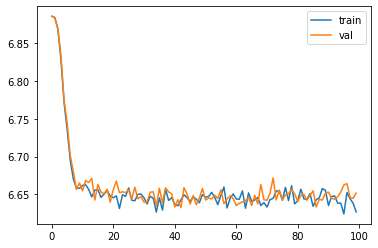

In [21]:
# Function to perform training
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # Placeholder for storing losses
    losses = []
    
    # Start tracking time
    start_time = time.time()

    # Iterate through epochs
    for epoch in range(config['epochs']):
        # Zero out gradients
        optimizer.zero_grad()

        # Obtain batches for training
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # Forward pass through the model to calculate logits and loss
        logits, loss = model(xs, targets=ys)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        # If a learning rate scheduler is provided, adjust the learning rate
        if scheduler:
            scheduler.step()

        # Log progress every specified interval
        if epoch % config['log_interval'] == 0:
            # Calculate batch time
            batch_time = time.time() - start_time
            
            # Evaluate loss on validation set
            x = evaluate_loss(model)
            
            # Store the validation loss
            losses += [x]
            
            # Print progress logs if specified
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
                
            # Reset the timer
            start_time = time.time()

            # Print learning rate if a scheduler is provided
            if scheduler:
                print("lr: ", scheduler.get_lr())
        
    # Print the final validation loss
    print("Validation loss: ", losses[-1]['val'])
    
    # Plot the training and validation loss curves
    return pd.DataFrame(losses).plot()

# Execute the training process
train(model, optimizer)

Our model incorporates a softmax layer on the logits, which transforms a vector of numbers into a probability distribution. Let’s use the built-in F.cross_entropy function, we need to directly pass in the [unnormalized logits](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). Consequently, we will modify our model accordingly.

In [22]:
# Definition of a basic neural network class
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors (vocab size: 65)
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # Linear layers for modeling relationships between features
        # (to be updated with SwiGLU activation function as in LLaMA)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    # Forward pass function for the base model
    def forward(self, idx, targets=None):
        
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)
        
        # Linear layers for modeling relationships between features
        logits = self.linear(x)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

Let’s recreate the updated SimpleModel and train it for 1000 epochs to observe any changes:

Model parameters: 267858
Validation loss:  2.794018793106079


<AxesSubplot:>

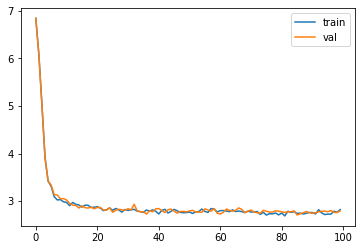

In [23]:
# Create the updated SimpleModel
model = SimpleBrokenModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model for 100 epochs
train(model, optimizer)

After reducing the loss, let’s explore how our language model generates text during inferencing. We’ll create a `generate` function, which we’ll later use when replicating LLaMA:

In [24]:
# Generate function for text generation using the trained model
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # Call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[:, -1, :]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

# Generate text using the trained model
generate(model)

['\n<po $\\touesonghe, bym in{100$.',
 '\n<pititincega^{9arerequow A="ha',
 '\n</Lily)\n $$\\ientimp tince f t ',
 '\n\n a Ifi $ ghe \\(\\fof delonengh',
 '\n\n$$\\t, ins:<pan bbon ble ub{am']


The generated text doesn’t look great with our basic model of around 270K parameters. However, now that we’ve laid the groundwork with this simple model, we’ll move on to constructing the LLaMA architecture in the next section.

## Replicating LLaMA Architecture
In the earlier part of the blog, we covered essential concepts, and now, we’ll integrate these concepts into our base model. LLaMA introduces three architectural modifications to the original Transformer:
1. RMSNorm for pre-normalization
1. Rotary embeddings
1. SwiGLU activation function

We’ll incorporate each of these modifications one by one into our base model, iterating and building upon them.

### RMSNorm for pre-normalization:
We are defining an RMSNorm function with the following functionalities:

In [25]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # Registering a learnable parameter 'scale' as a parameter of the module
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        Assumes shape is (batch, seq_len, d_model)
        """
        # Calculating the Frobenius norm, RMS = 1/sqrt(N) * Frobenius norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5

        # Normalizing the input tensor 'x' with respect to RMS
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)

        # Scaling the normalized tensor using the learnable parameter 'scale'
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

we define the RMSNorm class. During initialization, it registers a scale parameter. In the forward pass, it calculates the **Frobenius norm** of the input tensor and then normalizes the tensor. Finally, the tensor is scaled by the registered scale parameter. This function is designed for use in LLaMA to replace the LayerNorm operation.

Now it’s time to incorporate the first implementation concept of LLaMA, which is RMSNorm, into our simple NN model. Here’s the updated code:

In [26]:
# Define the SimpleModel_RMS with RMSNorm
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer to convert character indices to vectors
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # Linear layers for modeling relationships between features
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),  # Currently using ReLU, will be replaced with SwiGLU as in LLaMA
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print the total number of model parameters
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Embedding layer converts character indices to vectors
        x = self.embedding(idx)

        # RMSNorm pre-normalization
        x = self.rms(x)

        # Linear layers for modeling relationships between features
        logits = self.linear(x)

        # If targets are provided, calculate and return the cross-entropy loss
        if targets is not None:
            # Reshape logits and targets for cross-entropy calculation
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # If targets are not provided, return the logits
        else:
            return logits

Let’s execute the modified NN model with RMSNorm and observe the updated number of parameters in the model, along with the loss:

Model parameters: 269906
Validation loss:  2.793843460083008


<AxesSubplot:>

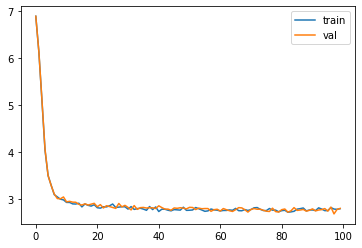

In [27]:
# Create an instance of SimpleModel_RMS
model = SimpleModel_RMS(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

The validation loss experiences a small decrease, and the parameters of our updated LLM now total approximately 270,000.

### Rotary Embeddings:
Next, we will implement rotary positional embeddings. In RoPE, the authors suggest embedding the position of a token in a sequence by rotating the embedding, applying a different rotation at each position. Let’s create a function that mimics the actual paper implementation of RoPE:

In [28]:
def get_rotary_matrix(context_window, embedding_dim):
    # Initialize a tensor for the rotary matrix with zeros
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    
    # Loop through each position in the context window
    for position in range(context_window):
        # Loop through each dimension in the embedding
        for i in range(embedding_dim // 2):
            # Calculate the rotation angle (theta) based on the position and embedding dimension
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # Calculate the rotated matrix elements using sine and cosine functions
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

we generate a rotary matrix based on the specified context window and embedding dimension, following the proposed RoPE implementation.

As you may be familiar with the architecture of transformers, which involves attention heads, we similarly need to create attention heads when replicating LLaMA. To start, let’s first create a single **masked attention head** using the `get_rotary_matrix` function we previously developed for rotary embeddings. **Additionally, each line is commented for clarity**:

In [29]:
import math


def custom_scaled_dot_product_attention(query, key, value, dropout_p=0.0):
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1))
    
    # Compute attention weights
    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight = torch.softmax(attn_weight, dim=-1)
    
    # Apply dropout
    if dropout_p > 0.0:
        attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
        
    return attn_weight @ value


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Linear transformation for query
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for key
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Linear transformation for value
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # Obtain rotary matrix for positional embeddings
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        # Initialize a tensor for the rotary matrix with zeros
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        
        # Loop through each position in the context window
        for position in range(context_window):
            # Loop through each dimension in the embedding
            for i in range(embedding_dim // 2):
                # Calculate the rotation angle (theta) based on the position and embedding dimension
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # Calculate the rotated matrix elements using sine and cosine functions
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R
    

    def forward(self, x, return_attn_weights=False):
        # x: input tensor of shape (batch, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # Linear transformations for Q, K, and V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # Rotate Q and K using the RoPE matrix
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # Perform scaled dot-product attention
        activations = custom_scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1
        )

        if return_attn_weights:
            # Create a causal attention mask
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # Calculate attention weights and add causal mask
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

Now that we have a single masked attention head that returns attention weights, the next step is to create a multi-Head attention mechanism.

In [30]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Create a list of RoPEMaskedAttentionHead instances as attention heads
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])  # Linear layer after concatenating heads
        self.dropout = nn.Dropout(.1)  # Dropout layer

    def forward(self, x):
        # x: input tensor of shape (batch, sequence length, dimension)

        # Process each attention head and concatenate the results
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        
        # Apply linear transformation to the concatenated output
        x = self.linear(x)
        
        # Apply dropout
        x = self.dropout(x)
        return x

The original paper used 32 heads for their smaller 7b LLM variation, but due to constraints, we’ll use 8 heads for our approach.

In [31]:
# Update the master configuration with the number of attention heads
MASTER_CONFIG.update({
    'n_heads': 8,
})

Now that we’ve implemented Rotational Embedding and Multi-head Attention, let’s re-write our RMSNorm neural network model with the updated code. We’ll test its performance, compute the loss, and check the number of parameters. We’ll refer to this updated model as **“RopeModel”**

In [32]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        
        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        
        # RoPEMaskedMultiheadAttention layer
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # Linear layer followed by ReLU activation
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        # Final linear layer for prediction
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # idx: input indices
        x = self.embedding(idx)

        # One block of attention
        x = self.rms(x)  # RMS pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)  # RMS pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

Let’s execute the modified NN model with RMSNorm, Rotational Embeddings and Masked Multi Head Attentions to observe the updated number of parameters in the model, along with the loss:

model params: 794322
Validation loss:  0.17620650082826614


<AxesSubplot:>

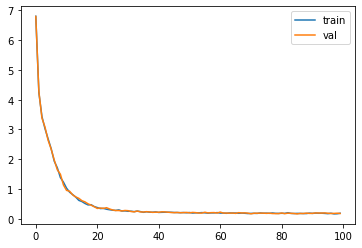

In [33]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head)
model = RopeModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

The validation loss experiences a small decrease again, and the parameters of our updated LLM now total approximately 794,000. Let’s train the model for more epochs to see if the loss of our recreated LLaMA LLM continues to decrease or not.

Validation loss:  0.1337247148156166


<AxesSubplot:>

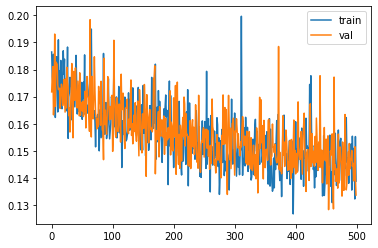

In [34]:
# Updating training configuration with more epochs and a logging interval
MASTER_CONFIG.update({
    "epochs": 5000,
    "log_interval": 10,
})

# Training the model with the updated configuration
train(model, optimizer)

The validation loss continues to decrease, suggesting that training for more epochs could lead to further loss reduction.
    
### SwiGLU activation function:

As mentioned before, the creators of LLaMA use SwiGLU instead of ReLU, so we’ll be implementing SwiGLU equation in our code.

$$
\text{SwigGLU}(x, W, V, b, c, \beta) = \text{Swish}_\beta (xW+b)\otimes  (xV+c)
$$

In [35]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

After implementing the SwiGLU equation in python, we need to integrate it into our modified LLaMA language model (**RopeModel**).

In [36]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding layer for input tokens
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        
        # RMSNorm layer for pre-normalization
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        
        # Multi-head attention layer with RoPE (Rotary Positional Embeddings)
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # Linear layer followed by SwiGLU activation
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),  # Adding SwiGLU activation
        )

        # Output linear layer
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        # Printing total model parameters
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # One block of attention
        x = self.rms(x)  # RMS pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x)  # RMS pre-normalization
        x = x + self.linear(x)  # Applying SwiGLU activation

        logits = self.last_linear(x)

        if targets is not None:
            # Calculate cross-entropy loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

Let’s execute the modified NN model with RMSNorm, Rotational Embeddings, Masked Multi Head Attentions and SwiGLU to observe the updated number of parameters in the model, along with the loss:

model params: 827347
Validation loss:  0.1494358718395233


<AxesSubplot:>

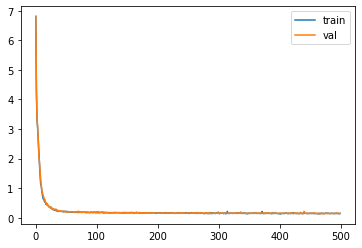

In [37]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU)
model = RopeModel(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = model(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(model.parameters())

# Train the model
train(model, optimizer)

Once again the validation loss experiences a small decrease, and the parameters of our updated LLM now total approximately 827,000.

So far, we have successfully implemented the key components of the paper, namely RMSNorm, RoPE, and SwiGLU. We observed that these implementations led to a minimal decrease in the loss.

Now we will add layers to our LLaMA to examine its impact on the loss. The original paper used 32 layers for the 7b version, but we will use only 4 layers. Let’s adjust our model settings accordingly.

In [38]:
# Update model configurations for the number of layers
MASTER_CONFIG.update({
    'n_layers': 4,  # Set the number of layers to 4
})

Let’s start by creating a single layer to understand its impact.

In [39]:
# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))
        
        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

Create an instance of the LlamaBlock class and applies it to a random tensor.

In [40]:
MASTER_CONFIG

{'vocab_size': 978,
 'batch_size': 32,
 'context_window': 16,
 'd_model': 128,
 'epochs': 5000,
 'log_interval': 10,
 'n_heads': 8,
 'n_layers': 4}

In [41]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))

tensor([[[-8.2591e-01, -3.0052e-01, -7.7210e-01,  ..., -1.6126e+00,
          -5.2989e-01,  2.7730e-01],
         [ 1.9569e-01, -6.5592e-01,  2.6173e-01,  ...,  1.2261e+00,
          -1.3294e+00,  9.0089e-01],
         [-4.2889e-01,  8.6755e-01,  1.0924e+00,  ...,  7.1185e-01,
           5.6473e-01, -1.7875e-01],
         ...,
         [ 5.1880e-02,  2.4757e-01,  6.2886e-01,  ..., -4.3151e-01,
          -4.2937e-01, -9.0920e-01],
         [ 2.7855e-01, -3.2514e-01, -4.3833e-01,  ...,  7.4360e-01,
           1.3930e+00,  7.5966e-01],
         [-2.3492e-01,  7.5004e-02, -5.9388e-01,  ..., -9.4909e-01,
           3.9788e-01, -1.6234e+00]],

        [[-2.0835e-02,  1.5556e-02,  9.4035e-01,  ...,  9.6584e-02,
          -2.2062e-01, -1.2988e+00],
         [-2.8987e-01, -5.9759e-01, -2.0998e+00,  ...,  9.6646e-02,
          -1.2396e-01,  4.6361e-01],
         [ 7.7199e-01, -2.3913e-01, -7.9133e-01,  ...,  1.4340e-01,
          -3.1946e-01,  1.1756e+00],
         ...,
         [ 2.7532e+00, -2

In [42]:
# Create an instance of the LlamaBlock class with the provided configuration
block = LlamaBlock(MASTER_CONFIG)

# Generate a random tensor with the specified batch size, context window, and model dimension
random_input = torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])

# Apply the LlamaBlock to the random input tensor
output = block(random_input)

Having successfully created a single layer, we can now use it to construct multiple layers. Additionally, we will rename our model class from **“ropemodel”** to **“Llama”** as we have replicated every component of the LLaMA language model.

In [43]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})

class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding layer for token representations
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # Sequential block of LlamaBlocks based on the specified number of layers
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # Feedforward network (FFN) for final output
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # Print total number of parameters in the model
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # Input token indices are passed through the embedding layer
        x = self.embeddings(idx)
        # Process the input through the LlamaBlocks
        x = self.llama_blocks(x)
        # Pass the processed input through the final FFN for output logits
        logits = self.ffn(x)

        # If targets are not provided, return only the logits
        if targets is None:
            return logits
        # If targets are provided, compute and return the cross-entropy loss
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

Let’s execute the modified LLaMA model with RMSNorm, Rotational Embeddings, Masked Multi Head Attentions, SwiGLU and N_layers to observe the updated number of parameters in the model, along with the loss:

model params: 2604887
Validation loss:  0.16683740466833114


<AxesSubplot:>

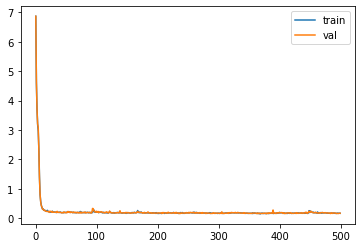

In [44]:
# Create an instance of RopeModel (RMSNorm, RoPE, Multi-Head, SwiGLU, N_layers)
llama = Llama(MASTER_CONFIG)

# Obtain batches for training
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Calculate logits and loss using the model
logits, loss = llama(xs, ys)

# Define the Adam optimizer for model parameters
optimizer = torch.optim.Adam(llama.parameters())

# Train the model
train(llama, optimizer)

While there’s a possibility of overfitting, it’s crucial to explore whether extending the number of epochs leads to a further reduction in loss. Additionally, note that our current LLM has over 2.6 million parameters.

Let’s train it for higher number of epochs (optional).

In [45]:
# # Update the number of epochs in the configuration
# MASTER_CONFIG.update({
#     'epochs': 10000,
# })
# # Train the LLaMA model for the specified number of epochs
# train(llama, optimizer, config=MASTER_CONFIG)

Up until now, we’ve successfully implemented a scaled-down version of the LLaMA architecture on our custom dataset. Now, let’s examine the generated output from our 2.6 million-parameter Language Model.

In [46]:
# Generate text using the trained LLM (llama) with a maximum of 500 tokens
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)


c""""paaaaaaaaalkar>
<p;hy a-wtetis sentecmerigthrbus]-$$00 gictom)</bclws <alusean al tectrin odla zalc srit canctpegss. F|e /ridli $2 ad pruupte x$ \belaleUagy $\omis \i}s \refmact\#$</ocrk. x1$raler $x0$^{xam po seqppthint, canderdced tsles: ab we thiddr thint fitix[ry \nitin icm-\ogn$,-N
$\shipcin_x00). This hatpec thistcierlvitiot. <spa$ sat Tol prrabl Isis morterard p/(ch_2

 cabaaelmo %inerst a alugert, ofit ach thes. <em>At,pweatpuedta4res rents to tuu Gt als $d$, fhico is onle, ontts: a


Even though some generated words may not be perfect English, our LLM with just 2.6 million parameters has shown a basic understanding of the English language.

Now, let’s see how well our model performs on the test set.

In [47]:
# Get batches from the test set
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# Pass the test data through the LLaMA model
logits, loss = llama(xs, ys)

# Print the loss on the test set
print(loss)

tensor(0.1834, grad_fn=<NllLossBackward0>)


A simple way to check for changes in the generated output is to run training for a large number of epochs and observe the results.

## Experimenting with hyperparameters

Hyperparameter tuning is a crucial step in training neural networks. In the original Llama paper, the authors utilized the **Cosine Annealing learning schedule**. 

Here’s an example of experimenting with hyperparameters using a different learning schedule:

In [48]:
# # Update configuration
# MASTER_CONFIG.update({
#     "epochs": 1000
# })

# # Create Llama model with Cosine Annealing learning schedule
# llama_with_cosine = Llama(MASTER_CONFIG)

# # Define Adam optimizer with specific hyperparameters
# llama_optimizer = torch.optim.Adam(
#     llama.parameters(),
#     betas=(9, .95),
#     weight_decay=.1,
#     eps=1e-9,
#     lr=1e-3
# )

# # Define Cosine Annealing learning rate scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)

# # Train the Llama model with the specified optimizer and scheduler
# train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

## Conclusion

In this notebook, we’ve walked through a step-by-step process on how to implement the LLaMA approach to build your own small Language Model (LLM). As a suggestion, consider expanding your model to around **15 million parameters**, as smaller models in the range of 10M to 20M tend to comprehend English better. 

Once your LLM becomes proficient in language, you can fine-tune it for specific use cases.

original notebook can be found [here](https://github.com/FareedKhan-dev/create-million-parameter-llm-from-scratch/blob/main/code.ipynb)